In [1]:
# TensorFlow's Keras API for image data augmentation and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Matplotlib and Seaborn for plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NumPy for numerical operations
import numpy as np

# Random for generating random numbers
import random

# TensorFlow for machine learning operations
import tensorflow as tf

# Keras Model and layers for building the U-Net architecture
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Activation, MaxPool2D, Concatenate

# Regularizers and Optimizers for the model
from keras.regularizers import l2
from keras.optimizers import Adam, Nadam

# Callbacks for model training
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Scikit-learn metrics for evaluation
from sklearn.metrics import confusion_matrix, classification_report

### Generation of data batches

In [2]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generate_data_batches(data_dir, batch_size, target_size, seed=None, train_augmentation=False):


    # Ensure images are inside a "class1" subfolder
    for subset in ['train', 'valid', 'test']:
        for category in ['images', 'masks']:
            subfolder_path = os.path.join(data_dir, subset, category, "class1")
            os.makedirs(subfolder_path, exist_ok=True)
            for file in os.listdir(os.path.join(data_dir, subset, category)):
                src = os.path.join(data_dir, subset, category, file)
                dst = os.path.join(subfolder_path, file)
                if os.path.isfile(src):
                    os.rename(src, dst)  # Move images inside "class1"

    # Rescaling factor
    rescale_factor = 1.0 / 255.0

    # Set random seed if provided
    if seed is not None:
        np.random.seed(seed)

    # Data augmentation for training set
    train_data_generator = ImageDataGenerator(
        rescale=rescale_factor,
        horizontal_flip=train_augmentation,
        vertical_flip=train_augmentation,
        rotation_range=20 if train_augmentation else 0,
        zoom_range=0.2 if train_augmentation else 0,
        shear_range=0.2 if train_augmentation else 0,
        width_shift_range=0.2 if train_augmentation else 0,
        height_shift_range=0.2 if train_augmentation else 0,
        brightness_range=[0.7, 1.3] if train_augmentation else None,
        fill_mode='reflect'
    )

    valid_test_data_generator = ImageDataGenerator(rescale=rescale_factor)

    # Data generators
    train_images_generator = train_data_generator.flow_from_directory(
        os.path.join(data_dir, 'train/images'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=True,
        seed=seed
    )

    train_masks_generator = train_data_generator.flow_from_directory(
        os.path.join(data_dir, 'train/masks'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        color_mode='grayscale',
        shuffle=True,
        seed=seed
    )

    valid_images_generator = valid_test_data_generator.flow_from_directory(
        os.path.join(data_dir, 'valid/images'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False,
        seed=seed
    )

    valid_masks_generator = valid_test_data_generator.flow_from_directory(
        os.path.join(data_dir, 'valid/masks'),
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        color_mode='grayscale',
        shuffle=False,
        seed=seed
    )

    test_images_generator = valid_test_data_generator.flow_from_directory(
        os.path.join(data_dir, 'test/images'),
        target_size=target_size,
        batch_size=100,
        class_mode=None,
        shuffle=False,
        seed=seed
    )

    test_masks_generator = valid_test_data_generator.flow_from_directory(
        os.path.join(data_dir, 'test/masks'),
        target_size=target_size,
        batch_size=100,
        class_mode=None,
        color_mode='grayscale',
        shuffle=False,
        seed=seed
    )

    return (
        train_images_generator, train_masks_generator,
        valid_images_generator, valid_masks_generator,
        test_images_generator, test_masks_generator
    )


In [3]:
data_dir = './new_data/'
batch_size = 8
seed = 123
target_size = (256, 256)

# Generate the data batches using the specified parameters
(train_images_gen, train_masks_gen,
 validation_images_gen, validation_masks_gen,
 test_images_gen, test_masks_gen) = generate_data_batches(
    data_dir,
    batch_size,
    target_size=target_size,
    seed=seed,
    train_augmentation=True
)

# Pack train generator as `(x, y)` and validation genereators as `(x_val, y_val)`
train_generator = zip(train_images_gen, train_masks_gen)
val_generator = zip(validation_images_gen, validation_masks_gen)

Found 600 images belonging to 1 classes.
Found 600 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 200 images belonging to 1 classes.


<a name="train-batches"></a>
#### Train batches

In [4]:
# Get the number of samples in the train images
train_samples = train_images_gen.samples

# Get the batch size
batch_size = train_images_gen.batch_size

# Calculate the number of steps per epoch (number of batches)
train_steps = train_samples / batch_size

# Print the number of samples, batch size, and number of batches
print("Train Images")
print("Number of samples:", train_samples)
print("Batch size:", batch_size)
print("Number of batches (train steps):", round(train_steps))

Train Images
Number of samples: 600
Batch size: 8
Number of batches (train steps): 75


In [5]:
# Get the number of samples in the train masks
train_samples = train_masks_gen.samples

# Get the batch size
batch_size = train_masks_gen.batch_size

# Calculate the number of steps per epoch (number of batches)
train_steps = train_samples / batch_size

# Print the number of samples, batch size, and number of batches
print("Train Masks")
print("Number of samples:", train_samples)
print("Batch size:", batch_size)
print("Number of batches (train steps):", round(train_steps))

Train Masks
Number of samples: 600
Batch size: 8
Number of batches (train steps): 75


In [6]:
batch_images = next(train_images_gen)
batch_masks = next(train_masks_gen)

print("Batch Images Shape:", batch_images.shape)
print("Batch Masks Shape:", batch_masks.shape)


Batch Images Shape: (8, 256, 256, 3)
Batch Masks Shape: (8, 256, 256, 1)


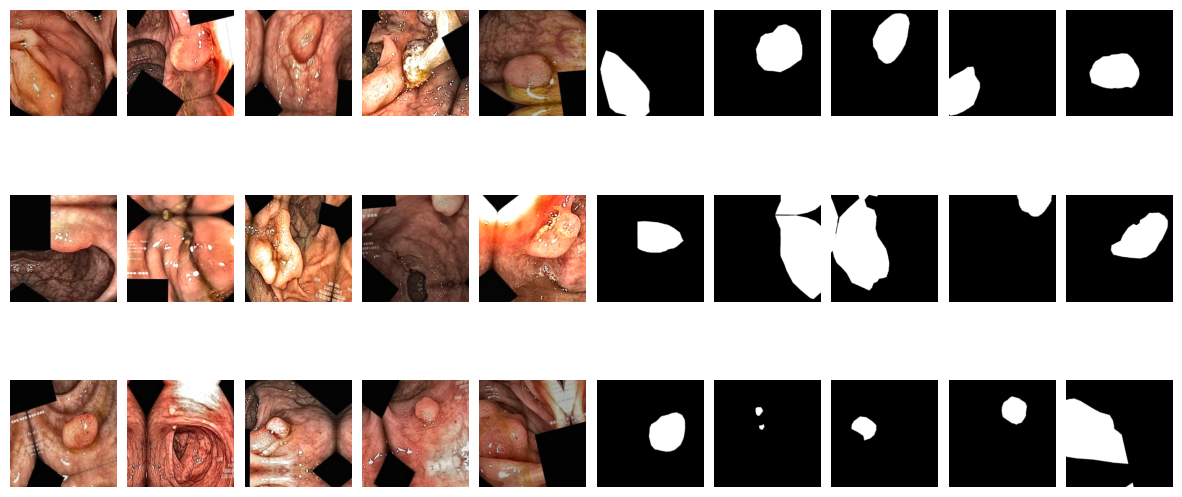

In [7]:
# Set the number of batches and images per batch to plot
num_batches = 3
images_per_batch = 5

# Plot the images and masks
fig, axes = plt.subplots(num_batches, 2 * images_per_batch, figsize=(15, 7))

# Iterate over the batches and plot the images and masks
for i in range(num_batches):
    batch_images = next(train_images_gen)[:images_per_batch]
    batch_masks = next(train_masks_gen)[:images_per_batch]

    for j in range(images_per_batch):
        # Plot the image
        axes[i, j].imshow(batch_images[j], cmap='gray')
        axes[i, j].axis('off')

        # Plot the mask
        axes[i, j + images_per_batch].imshow(batch_masks[j], cmap='gray')
        axes[i, j + images_per_batch].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()

In [8]:
print("Minimum train image pixel value:", batch_images[0].min())
print("Maximum train image pixel value:", batch_images[0].max())
print("Minimum train mask pixel value:", batch_masks[0].min())
print("Maximum train mask pixel value:", batch_masks[0].max())

Minimum train image pixel value: 0.0
Maximum train image pixel value: 0.9568628
Minimum train mask pixel value: 0.0
Maximum train mask pixel value: 0.9568628


<a name="validation-batches"></a>
#### Validation batches

In [9]:
# Get the number of samples in the validation images
validation_samples = validation_images_gen.samples

# Get the batch size
batch_size = validation_images_gen.batch_size

# Calculate the number of steps per epoch (number of batches)
validation_steps = validation_samples / batch_size

# Print the number of samples, batch size, and number of batches
print("Validation Images")
print("Number of samples:", validation_samples)
print("Batch size:", batch_size)
print("Number of batches (validation steps):", round(validation_steps))

Validation Images
Number of samples: 200
Batch size: 8
Number of batches (validation steps): 25


In [10]:
# Get the number of samples in the validation masks
validation_samples = validation_masks_gen.samples

# Get the batch size
batch_size = validation_masks_gen.batch_size

# Calculate the number of steps per epoch (number of batches)
validation_steps = validation_samples / batch_size

# Print the number of samples, batch size, and number of batches
print("Validation Masks")
print("Number of validation samples:", validation_samples)
print("Batch size:", batch_size)
print("Number of validation batches (validation steps):", round(validation_steps))

Validation Masks
Number of validation samples: 200
Batch size: 8
Number of validation batches (validation steps): 25


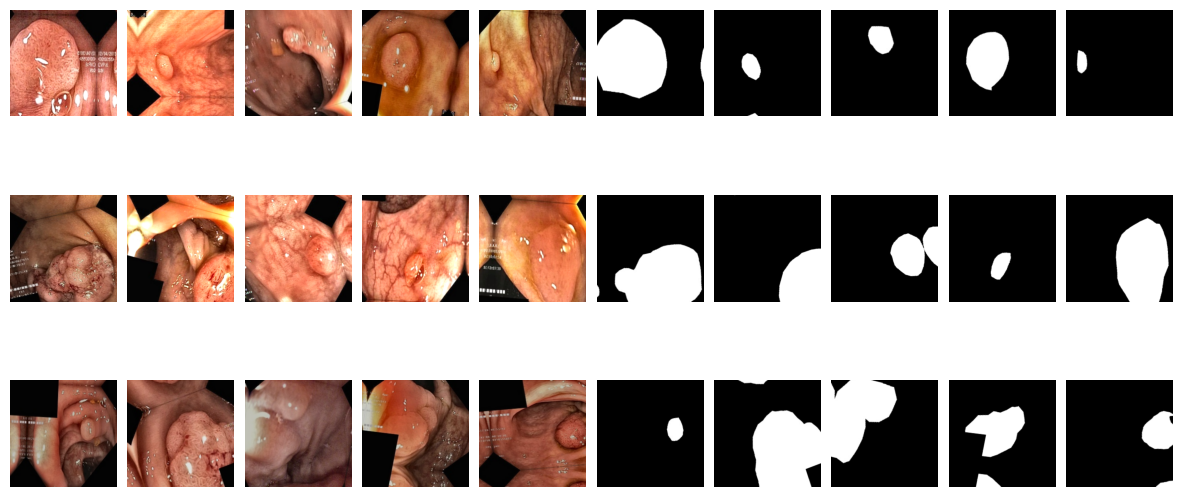

In [11]:
# Set the number of batches and images per batch to plot
num_batches = 3
images_per_batch = 5

# Plot the images and masks
fig, axes = plt.subplots(num_batches, 2 * images_per_batch, figsize=(15, 7))

# Iterate over the batches and plot the images and masks
for i in range(num_batches):
    batch_images = next(train_images_gen)[:images_per_batch]
    batch_masks = next(train_masks_gen)[:images_per_batch]


    for j in range(images_per_batch):
        # Plot the image
        axes[i, j].imshow(batch_images[j], cmap='gray')
        axes[i, j].axis('off')

        # Plot the mask
        axes[i, j + images_per_batch].imshow(batch_masks[j], cmap='gray')
        axes[i, j + images_per_batch].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()

In [12]:
print("Minimum validation image pixel value:", batch_images[0].min())
print("Maximum validation image pixel value:", batch_images[0].max())
print("Minimum validation mask pixel value:", batch_masks[0].min())
print("Maximum validation mask pixel value:", batch_masks[0].max())

Minimum validation image pixel value: 0.0
Maximum validation image pixel value: 0.75294125
Minimum validation mask pixel value: 0.0
Maximum validation mask pixel value: 0.75294125


<a name="test-batch"></a>
#### Test batch

In [13]:
test_images_gen.batch_size

100

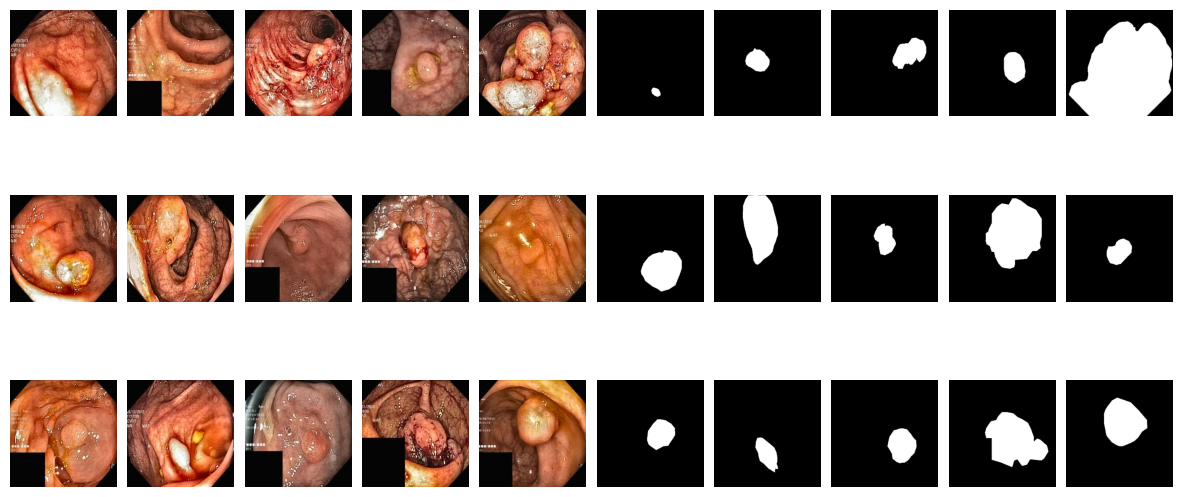

In [14]:
# Set the number of rows and columns for the grid
num_rows = 3
num_cols = 5
total_images = num_rows * num_cols # total of 15 images to display

# Plot the images and masks in a grid
fig, axes = plt.subplots(num_rows, 2 * num_cols, figsize=(15, 7))

# Get the test batch
# Get the next batch of images and masks from the test generators
test_batch_images, test_batch_masks = next(test_images_gen), next(test_masks_gen)


# Iterate over the images in the test batch and plot them in the grid
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j

        # Plot the image
        axes[i, j].imshow(test_batch_images[index], cmap='gray')
        axes[i, j].axis('off')

        # Plot the mask
        axes[i, j + num_cols].imshow(test_batch_masks[index], cmap='gray')
        axes[i, j + num_cols].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()

In [15]:
print("Minimum test image pixel value:", batch_images[0].min())
print("Maximum test image pixel value:", batch_images[0].max())
print("Minimum test mask pixel value:", batch_masks[0].min())
print("Maximum test mask pixel value:", batch_masks[0].max())

Minimum test image pixel value: 0.0
Maximum test image pixel value: 0.75294125
Minimum test mask pixel value: 0.0
Maximum test mask pixel value: 0.75294125
